# Предсказание действий покупателя

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.  

*Цель*  
Предсказать вероятность покупки в течение 90 дней  

*Задачи*  
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

# Описание данных
Данные находятся в нескольких файлах: apparel-purchases, apparel-messages, full_campaign_daily_event, full_campaign_daily_event_channel

`apparel-purchases`
Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например автотовары-аксессуары-освежители), но также может
включать в начале списка маркер распродажи или маркер женщинам/мужчинам.
Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594']. Как
обработать такие случаи – можете предлагать свои варианты решения.
- client_id идентификатор клиента
- quantity количество единиц товара
- price цена товара
- category_ids идентификаторы категорий
- date дата покупки
- message_id идентификатор сообщения из рассылки  

`apparel-messages`
Рассылки, которые были отправлены клиентам из таблицы покупок.
- bulk_campaign_id идентификатор рассылки
- client_id идентификатор клиента
- message_id идентификатор сообщения
- event действие с сообщением (отправлено, открыто, покупка…)
- channel канал рассылки
- date дата действия
- created_at дата-время полностью
  
`apparel-target_binary`
- client_id идентификатор клиента
- target клиент совершил покупку в целевом периоде
Общая база рассылок огромна, поэтому собрали для вас агрегированную по дням
статистику по рассылкам. Если будете создавать на основе этой статистики дополнительные
признаки, обратите внимание, что нельзя суммировать по колонкам nunique, потому что это
уникальные клиенты в пределах дня, у вас нет данных, повторяются ли они в другие дни)  

`full_campaign_daily_event`
Агрегация общей базы рассылок по дням и типам событий
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event* общее количество каждого события event
- nunique_event* количество уникальных client_id в каждом событии
* в именах колонок найдете все типы событий event
  
`full_campaign_daily_event_channel`
Агрегация по дням с учетом событий и каналов рассылки
- date дата
- bulk_campaign_id идентификатор рассылки
- count_event*_channel* общее количество каждого события по каналам
- nunique_event*_channel* количество уникальных client_id по событиям и каналам
* в именах колонок есть все типы событий event и каналов рассылки channel

In [1]:
!pip freeze > requirements.txt

In [2]:
!pip install phik -q
!pip install catboost -q

from phik import resources
from phik.report import plot_correlation_matrix
import numpy as np
import pandas as pd
from scipy import stats as st
import textwrap
import time

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Важно: используем Pipeline из imblearn

from matplotlib import pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import plotly.express as px
import seaborn as sns
import ast



# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   FunctionTransformer
                                  )
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score


# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer



# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV


# загружаем нужные модели

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import (DecisionTreeClassifier,
                          DecisionTreeRegressor)
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier


# загружаем функцию для работы с метриками
from sklearn.metrics import (roc_auc_score,
                             precision_score,
                             recall_score,
                             confusion_matrix,
                             make_scorer,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve,
                             classification_report
                            )


RANDOM_STATE = 77
TEST_SIZE = 0.25


# Подавляем FutureWarning, вызванный изменением поведения функции `mode`
import warnings
import scipy.stats
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy.stats")

#чтобы не было красных предупреждений
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)

## Загрузка данных

In [3]:
#загружаем данные с покупками клиентов
try:
    purchases = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/masterskaya_2.0/datasets/apparel-purchases.csv')
except:
    purchases = pd.read_csv('/datasets/apparel-purchases.csv')
#проверяем, что данные в таблицах соответствуют описанию
purchases.info()
purchases.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [4]:
#загружаем данные с рассылками клиентам 
try:
    messages = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/masterskaya_2.0/datasets/apparel-messages.csv')
except:
    messages = pd.read_csv('/datasets/apparel-messages.csv')
#проверяем, что данные в таблицах соответствуют описанию
messages.info()
messages.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [5]:
#загружаем данные с таргетом
try:
    apparel_target = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/masterskaya_2.0/datasets/apparel_target_binary.csv')
except:
    apparel_target = pd.read_csv('/datasets/apparel_target_binary.csv')
#проверяем, что данные в таблицах соответствуют описанию
apparel_target.info()
apparel_target.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [6]:
#загружаем данные 
try:
    full_campaign_daily_event = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/masterskaya_2.0/datasets/full_campaign_daily_event.csv')
except:
    full_campaign_daily_event = pd.read_csv('/datasets/full_campaign_daily_event.csv')
#проверяем, что данные в таблицах соответствуют описанию
full_campaign_daily_event.info()
full_campaign_daily_event.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [7]:
#загружаем данные
try:
    full_campaign_daily_event_channel = pd.read_csv('C:/Users/PC/Documents/Practicum/DataSceince/masterskaya_2.0/datasets/full_campaign_daily_event_channel.csv')
except:
    full_campaign_daily_event_channel = pd.read_csv('/datasets/full_campaign_daily_event_channel.csv')
#проверяем, что данные в таблицах соответствуют описанию
full_campaign_daily_event_channel.head(5)
full_campaign_daily_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

## Предобработка данных

### Переименование столбцов

Переименование столбцов не требуется, так как стилистически все в порядке, и названия столбцов на английском, а также отражают суть.

### Приведние данных к верному типу данных

Приведем даты к формату datetime, чтобы можно было их использовать для создания новых признаков.

In [8]:
purchases['date'] = pd.to_datetime(purchases['date'])
messages['date'] = pd.to_datetime(messages['date'])
messages['created_at'] = pd.to_datetime(messages['created_at'])
full_campaign_daily_event['date'] = pd.to_datetime(full_campaign_daily_event['date'])
full_campaign_daily_event_channel['date'] = pd.to_datetime(full_campaign_daily_event_channel['date'])

In [9]:
print('даты  purchases', purchases['date'].describe())
print('даты  messages', messages['date'].describe())
print('даты создания  messages', messages['created_at'].describe())
print('даты  full_campaign_daily_event', full_campaign_daily_event['date'].describe())
print('даты  purcfull_campaign_daily_event_channelhases', full_campaign_daily_event_channel['date'].describe())

даты  purchases count                           202208
mean     2023-03-17 02:49:35.739832064
min                2022-05-16 00:00:00
25%                2022-11-12 00:00:00
50%                2023-04-12 00:00:00
75%                2023-07-03 00:00:00
max                2024-02-16 00:00:00
Name: date, dtype: object
даты  messages count                         12739798
mean     2023-06-05 02:46:08.357990400
min                2022-05-19 00:00:00
25%                2022-12-19 00:00:00
50%                2023-07-20 00:00:00
75%                2023-11-21 00:00:00
max                2024-02-15 00:00:00
Name: date, dtype: object
даты создания  messages count                         12739798
mean     2023-06-05 13:58:11.168689408
min                2022-05-19 00:14:20
25%                2022-12-19 12:46:30
50%                2023-07-20 17:21:54
75%                2023-11-21 18:13:05
max                2024-02-15 23:58:40
Name: created_at, dtype: object
даты  full_campaign_daily_event count     

###  Поиск и удаление дубликатов

Проверим количество дубликатов в каждом датасете.

In [10]:
print('количество полных дубликатов в purchases', purchases.duplicated().sum())
print('количество полных дубликатов в messages', messages.duplicated().sum())
print('количество полных дубликатов в apparel_target', apparel_target.duplicated().sum())
print('количество полных дубликатов в full_campaign_daily_event', full_campaign_daily_event.duplicated().sum())
print('количество полных дубликатов в full_campaign_daily_event_channel', full_campaign_daily_event_channel.duplicated().sum())


количество полных дубликатов в purchases 73020
количество полных дубликатов в messages 48610
количество полных дубликатов в apparel_target 0
количество полных дубликатов в full_campaign_daily_event 0
количество полных дубликатов в full_campaign_daily_event_channel 0


Удалим дубликаты только в messages, так как мы уверены что это абсолютные дуликаты из-за столбца `created_at`. Насчет датасета с покупками мы не можем сказать, что это дубликаты, так как пользователей мог совершить одинаковые покупки в один и тот же день.

In [11]:
messages = messages.drop_duplicates()

### Работа с пропусками

Проверим наличие пропусков в каждом датасете.

In [12]:
print('Пропуски в purchases', purchases.isna().sum()[purchases.isna().sum()>0])
print('Пропуски в messages', messages.isna().sum()[messages.isna().sum()>0])
print('Пропуски в apparel_target', apparel_target.isna().sum()[apparel_target.isna().sum()>0])
print('Пропуски в full_campaign_daily_event', full_campaign_daily_event.isna().sum()[full_campaign_daily_event.isna().sum()>0])
print('Пропуски в full_campaign_daily_event_channel', full_campaign_daily_event_channel.isna().sum()[full_campaign_daily_event_channel.isna().sum()>0])


Пропуски в purchases Series([], dtype: int64)
Пропуски в messages Series([], dtype: int64)
Пропуски в apparel_target Series([], dtype: int64)
Пропуски в full_campaign_daily_event Series([], dtype: int64)
Пропуски в full_campaign_daily_event_channel Series([], dtype: int64)


Пропуски не обнаружены.

### Добавление новых признаков и удаление признаков

Рассмотрим сначала каждый датасет отдельно .

#### full_campaign_daily_event и full_campaign_daily_event_channel

Посмотри подробнее на маркетинговый метрики в таблицах `full_campaign_daily_event` и `full_campaign_daily_event_channel`.  

Эти термины относятся к метрикам в маркетинге, особенно в контексте email- и push-рассылок. Вот их расшифровка:

1. click_email
Клики по ссылкам в email-рассылке. Показывает, сколько пользователей перешли по ссылкам внутри письма.

2. click_mobile_push
Клики по push-уведомлениям на мобильных устройствах.

3. open_email
Открытия email-писем. Эта метрика показывает, сколько раз письмо было открыто (даже если один пользователь открыл его несколько раз).

4. open_mobile_push
Открятия push-уведомлений на мобильных устройствах.

5. purchase_email
Покупки, совершенных после взаимодействия с email-рассылкой. Это помогает оценить эффективность кампании по конверсии.

6. purchase_mobile_push
Покупки после взаимодействия с push-уведомлением.

7. soft_bounce_email
"мягкие отказы" (soft bounce) в email-рассылке. Это временная ошибка доставки (например, почтовый ящик переполнен или сервер временно недоступен).

8. subscribe_email
Подписки, оформленные через email-канал.

9. unsubscribe_email
Отписки от email-рассылок.

10. spam_email
Письма ушли в спам



В этой работе не будем считать уникальные метрики, рассмотрим только общие.  

Можем посчитать конверсию - процент покупок от количества переходов по ссылке.

например , Клики = (Количество кликов ÷ Количество отправленых писем) × 100 Клики по ссылкам = (Количество кликов ÷ Количество открытых писем) × 100
Покупки через email = (Количество покупок ÷ Количество открытых писем) × 100 Жалобы = (Количество жалоб ÷ Количество отправленных писем) × 100

и аналогично для пуш уведомлений

Добавим конверсию

In [13]:
full_campaign_daily_event['conversion_purchase'] = full_campaign_daily_event['count_purchase'] / full_campaign_daily_event['count_send']

full_campaign_daily_event['conversion_purchase'] = full_campaign_daily_event['conversion_purchase'].replace([np.inf, -np.inf], 0)
full_campaign_daily_event = full_campaign_daily_event.fillna(0)

In [14]:
full_campaign_daily_event_channel['conversion_purchase_email'] = \
full_campaign_daily_event_channel['count_purchase_email'] / full_campaign_daily_event_channel['count_send_email']

full_campaign_daily_event_channel['conversion_mobile_push'] = \
full_campaign_daily_event_channel['count_purchase_mobile_push'] / full_campaign_daily_event_channel['count_send_mobile_push']

full_campaign_daily_event_channel = full_campaign_daily_event_channel.fillna(0)
full_campaign_daily_event_channel = full_campaign_daily_event_channel.replace([np.inf, -np.inf], 0)

In [15]:
# удаление исходных признаков
keywords = ['_bounce', '_subscribe', '_unsubscribe', '_spam', 'nunique', 'count_']
col_to_drop = [col for col in full_campaign_daily_event.columns if any(keyword in col for keyword in keywords)]
full_campaign_daily_event = full_campaign_daily_event.drop(columns=col_to_drop)

In [16]:
# удаление исходных признаков
col_to_drop = [col for col in full_campaign_daily_event_channel.columns if any(keyword in col for keyword in keywords)]
full_campaign_daily_event_channel = full_campaign_daily_event_channel.drop(columns=col_to_drop)

#### messages

Преобразуем столбец event  числовой. Негативным событиям присовим -1, позитивным +1, нейтральным - 0

In [17]:
messages['event'].value_counts()

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

In [18]:
messages['event'] = messages['event'].str.replace('send', '0')
messages['event'] = messages['event'].str.replace('open', '1')
messages['event'] = messages['event'].str.replace('click', '1')
messages['event'] = messages['event'].str.replace('purchase', '1')
messages['event'] = messages['event'].str.replace('open', '1')
messages['event'] = messages['event'].str.replace('hard_bounce', '0')
messages['event'] = messages['event'].str.replace('soft_bounce', '0')
messages['event'] = messages['event'].str.replace('unsubscribe', '0')
messages['event'] = messages['event'].str.replace('hbq_spam', '0')
messages['event'] = messages['event'].str.replace('complain', '0')
messages['event'] = messages['event'].str.replace('close', '0')
messages['event'] = messages['event'].str.replace('subscribe', '0')


In [19]:
messages['event'] = pd.to_numeric(messages['event'])
messages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12691188 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             int64         
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 774.6+ MB


#### purchases

Поработаем с `category_ids`.

In [20]:
purchases['category_ids'].value_counts()

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

Так как в некоторых списках категорий на первом месте может стоять маркер распродажи или маркер мужского/женского, то предполодим , что этот маркер - это однозначное число на 1м месте.  

Обрабатывать категории будем следующим образом - оставим только одну - первую по порядку и неоднозначную.

In [21]:
#ast.literal_eval(x) — эта функция безопасно преобразует строку, которая выглядит как список, в настоящий список.
purchases['category_ids_new'] = purchases['category_ids'].apply(lambda x: ast.literal_eval(x)) 

#уберем однозначные символы , которые стоят на 1м месте
purchases['category_ids_new'] = purchases['category_ids_new'].apply(lambda x: x[0]
                                                                              if x is not None and x != [] and len(str(x[0]))>1
                                                                              else x[1]
                                                                                   if x is not None and x != []
                                                                                   else None    
                                                                   )
purchases = purchases.dropna()

In [22]:
purchases.sample(10)

,client_id,quantity,price,category_ids,date,message_id,category_ids_new
94142,1515915625557051798,1,1750.0,"['5562', '5630', '5548', '664']",2023-03-23,1515915625557051798-11207-641c57f025bbf,5562
45416,1515915625491328346,1,1609.0,"['4', '28', '58', '434']",2022-11-11,1515915625491328346-7803-636dfed5a260b,28
65261,1515915625574025229,1,365.0,"['4', '28', '290', '424']",2022-12-15,1515915625574025229-8725-639b2f04187ad,28
74589,1515915625548441959,1,839.0,"['4', '27', '84', '515']",2022-12-22,1515915625548441959-8902-63a2cef90dc3d,27
56523,1515915625566789392,1,399.0,"['4', '27', '1828', '1603']",2022-11-15,1515915625566789392-7845-63733583b2862,27
188302,1515915625559674048,1,199.0,"['4', '28', '228', '435']",2023-12-26,1515915625559674048-14383-658945ce0d8d7,28
188573,1515915625943252753,1,1119.0,"['5562', '5589', '5610', '1636']",2023-12-26,1515915625943252753-14391-658a9c94ea8b5,5562
51276,1515915625855060937,1,2099.0,"['4', '28', '62', '657']",2022-11-12,1515915625855060937-7810-636e5914380e7,28
155039,1515915625558989519,1,1075.0,"['4', '28', '57', '431']",2023-07-07,1515915625489577620-13456-64a7ddfe80bc6,28
170194,1515915625558324544,1,2043.0,"['4', '28', '62', '657']",2023-09-19,1515915625558324544-13815-65091d57c714f,28


In [23]:
print('было', purchases['category_ids'].nunique())
print('стало', purchases['category_ids_new'].nunique())
print('пропуски', purchases['category_ids_new'].isna().sum())

было 931
стало 18
пропуски 0


Получилось снизить уникальность категорий с 931 до 18.

Добавим столбец с количеством дней , прошедших с последней покупки. Но так как мы не знаем дату выгрузки , найдем максимальную дату и примем ее за "току отсчета", и от нее посчитаем количество дней для каждой покупки.

In [24]:
max_date = purchases['date'].max()
print(max_date)
purchases['days_last_purchases'] = (purchases['date'] - max_date).dt.days * -1
purchases.sample(5)

2024-02-16 00:00:00


,client_id,quantity,price,category_ids,date,message_id,category_ids_new,days_last_purchases
83942,1515915625593801805,1,2309.0,"['4', '29', '310', '500']",2023-01-25,1515915625593801805-9551-63cf7ead98df4,29,387
187144,1515915625932350752,1,139.0,"['6060', '6058', '6061', '5504']",2023-12-24,1515915625932350752-14356-65869a9999c0a,6060,54
64592,1515915625487340849,1,353.0,"['5562', '5536', '5829', '1679']",2022-12-15,1515915625589704388-8725-639b2f0448754,5562,428
90663,1515915625631499625,1,26.0,"['4', '44', '1571']",2023-03-09,1515915625631499625-10777-64098b2147c03,44,344
119498,1515915625586232008,1,1119.0,"['4', '28', '244', '432']",2023-05-06,1515915625491414914-12367-6454f133dbd4e,28,286


In [25]:
purchases['quantity'].value_counts()

quantity
1     194480
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

Покупки в основном совершаются по 1 штуке, поэтому можно было не вводить дополнительный признак  - выручка, так как цена в большинстве случаев будет равна выручке, но так как есть покупки , где количество превышает 1, все -таки  введем выручку и удалим цену.

In [26]:
purchases['revenue'] = purchases['quantity'] * purchases['price'] 

In [27]:
purchases = purchases.drop(columns=['date', 'category_ids', 'price'])

Теперь сгруппируем таблицу по client_id и message_id, затем по category_ids_new

In [28]:
group_purchases = purchases.groupby(['client_id', 'message_id'], as_index=False) \
    .agg({
        'quantity': 'sum',
        'revenue': 'sum',
        'days_last_purchases': 'mean'
    })


# Считаем моду и преобразуем в DataFrame
category_mode = purchases.groupby(['client_id', 'message_id'])['category_ids_new'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Объединяем результаты по общим индексам
group_purchases = group_purchases.merge(category_mode, on=['client_id', 'message_id'], how='left')

In [29]:
group_purchases.head()

,client_id,message_id,quantity,revenue,days_last_purchases,category_ids_new
0,1515915625468060902,1515915625468060902-4617-6290657dac196,7,6993.0,630.0,28
1,1515915625468061003,1515915625468061003-9148-63b54b04855a4,7,16235.0,408.0,28
2,1515915625468061099,1515915625468061099-4439-62834141aa538,1,299.0,640.0,28
3,1515915625468061100,1515915625468061100-14623-65c5c55eeb9e0,2,2098.0,6.0,27
4,1515915625468061170,1515915625468061170-11144-641ad2cda77a2,2,5398.0,327.0,18


In [30]:
group_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58329 entries, 0 to 58328
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   client_id            58329 non-null  int64  
 1   message_id           58329 non-null  object 
 2   quantity             58329 non-null  int64  
 3   revenue              58329 non-null  float64
 4   days_last_purchases  58329 non-null  float64
 5   category_ids_new     58329 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 2.7+ MB


#### Выводы по результатам шага

Проведена предобработка данных, выявлены и устранены полные дубликаты.   

Добавлены новые признаки в таблицы purchases и full_campaign_daily_event, full_campaign_daily_event_channel

Пропуски в данных не обнаружены.

### Объединенение таблиц

Так как объединение будем проводить по id , то помсотрим сколько уникальных значений по каждому id

In [31]:
print('purchases')
print('Количество уникальных значений message_id', purchases['message_id'].nunique())
print('Количество уникальных значений client_id', purchases['client_id'].nunique())
print()
print('messages')
print('Количество уникальных значений message_id', messages['message_id'].nunique())
print('Количество уникальных значений client_id', messages['client_id'].nunique())
print('Количество уникальных значений bulk_campaign_id', messages['bulk_campaign_id'].nunique())
print()
print('apparel_target')
print('Количество уникальных значений client_id', apparel_target['client_id'].nunique())
print()
print('full_campaign_daily_event')
print('Количество уникальных значений bulk_campaign_id', full_campaign_daily_event['bulk_campaign_id'].nunique())
print()
print('full_campaign_daily_event_channel')
print('Количество уникальных значений bulk_campaign_id', full_campaign_daily_event_channel['bulk_campaign_id'].nunique())

purchases
Количество уникальных значений message_id 50202
Количество уникальных значений client_id 49848

messages
Количество уникальных значений message_id 9061667
Количество уникальных значений client_id 53329
Количество уникальных значений bulk_campaign_id 2709

apparel_target
Количество уникальных значений client_id 49849

full_campaign_daily_event
Количество уникальных значений bulk_campaign_id 3181

full_campaign_daily_event_channel
Количество уникальных значений bulk_campaign_id 3181


За основу возьмем датасет messages и в него сначала присоеденим все данные по  events из датасетов full_campaign_daily_event_channel и full_campaign_daily_event  по (bulk_campaign_id и date). Далее удалим строки с пропусками и в полученную таблицу добавим данные из уже сгруппированной таблицы purchases, объединение произведем по client_id и message_id.

In [32]:
#объединяем данные по рассылкам
data = messages.merge(full_campaign_daily_event, on=['bulk_campaign_id', 'date'], how='left')\
               .merge(full_campaign_daily_event_channel, on=['bulk_campaign_id', 'date'], how='left')
data = data.drop(columns=['date', 'bulk_campaign_id', 'message_id'])

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12691188 entries, 0 to 12691187
Data columns (total 7 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   client_id                  int64         
 1   event                      int64         
 2   channel                    object        
 3   created_at                 datetime64[ns]
 4   conversion_purchase        float64       
 5   conversion_purchase_email  float64       
 6   conversion_mobile_push     float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 677.8+ MB


In [34]:
print('Длина датасета messages', len(messages))
print('Длина датасета data', len(data))
print()
print('Пропуски')
data.isna().sum()[data.isna().sum()>0]

Длина датасета messages 12691188
Длина датасета data 12691188

Пропуски


conversion_purchase          1848
conversion_purchase_email    1848
conversion_mobile_push       1848
dtype: int64

In [35]:
data = data.dropna()

In [36]:
data_group = data.groupby(['client_id'], as_index=False).agg({
        'event': 'sum', 
        'conversion_purchase': 'mean',
        'conversion_purchase_email': 'mean',
        'conversion_mobile_push': 'mean'
        })

channel_mode = data.groupby(['client_id'])['channel'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Объединяем результаты по общим id
data_group_messages = data_group.merge(channel_mode, on=['client_id'], how='left')


In [37]:
#присоединяем данные с покупками
data = data_group_messages.merge(group_purchases, on=['client_id'], how='left')
data = data.drop(columns=['message_id'])

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60893 entries, 0 to 60892
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  60893 non-null  int64  
 1   event                      60893 non-null  int64  
 2   conversion_purchase        60893 non-null  float64
 3   conversion_purchase_email  60893 non-null  float64
 4   conversion_mobile_push     60893 non-null  float64
 5   channel                    60893 non-null  object 
 6   quantity                   49545 non-null  float64
 7   revenue                    49545 non-null  float64
 8   days_last_purchases        49545 non-null  float64
 9   category_ids_new           49545 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 4.6+ MB


In [39]:
print('Пропуски')
data.isna().sum()[data.isna().sum()>0]

Пропуски


quantity               11348
revenue                11348
days_last_purchases    11348
category_ids_new       11348
dtype: int64

In [40]:
data = data.dropna()

Посмотрим, остались ли дубликаты, но удалять их не будем , так как это могли присоединиться разные покупки одного и того же покупателя

In [41]:
data.duplicated().sum()

18

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49545 entries, 0 to 60891
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  49545 non-null  int64  
 1   event                      49545 non-null  int64  
 2   conversion_purchase        49545 non-null  float64
 3   conversion_purchase_email  49545 non-null  float64
 4   conversion_mobile_push     49545 non-null  float64
 5   channel                    49545 non-null  object 
 6   quantity                   49545 non-null  float64
 7   revenue                    49545 non-null  float64
 8   days_last_purchases        49545 non-null  float64
 9   category_ids_new           49545 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 4.2+ MB


In [43]:
print('Количество уникальных значений client_id в data', data['client_id'].nunique())

Количество уникальных значений client_id в data 41981


Перед присоединением таргета по client_id сгруппируем данные в промежуточном датасете по client_id.

In [44]:
data_group = data.groupby(['client_id'], as_index=False).agg({
        'quantity': 'sum',
        'revenue': 'sum',
        'event': 'sum',
        'days_last_purchases': 'mean', 
        'conversion_purchase': 'mean',
        'conversion_purchase_email': 'mean',
        'conversion_mobile_push': 'mean'
    
    })




# Считаем моду в категориальных признаках и преобразуем в DataFrame

category_mode = data.groupby(['client_id'])['category_ids_new'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()


channel_mode = data.groupby(['client_id'])['channel'] \
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).reset_index()

# Объединяем результаты по общим id
data = data_group.merge(category_mode, on=['client_id'], how='left')\
                                 .merge(channel_mode, on=['client_id'], how='left')


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41981 entries, 0 to 41980
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   client_id                  41981 non-null  int64  
 1   quantity                   41981 non-null  float64
 2   revenue                    41981 non-null  float64
 3   event                      41981 non-null  int64  
 4   days_last_purchases        41981 non-null  float64
 5   conversion_purchase        41981 non-null  float64
 6   conversion_purchase_email  41981 non-null  float64
 7   conversion_mobile_push     41981 non-null  float64
 8   category_ids_new           41981 non-null  object 
 9   channel                    41981 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 3.2+ MB


In [46]:
#добавляем таргет в финальный датасет
data = data.merge(apparel_target, on=['client_id'], how='left')
print('Количество уникальных значений client_id в apparel_target', apparel_target['client_id'].nunique())
print('Количество уникальных значений client_id в data', data['client_id'].nunique())
data.isna().sum()[data.isna().sum()>0]

Количество уникальных значений client_id в apparel_target 49849
Количество уникальных значений client_id в data 41981


Series([], dtype: int64)

In [47]:
data = data.dropna()

In [48]:
#устаналиваем client_id индексом
data.set_index('client_id', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41981 entries, 1515915625468060902 to 1515915626010261344
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   quantity                   41981 non-null  float64
 1   revenue                    41981 non-null  float64
 2   event                      41981 non-null  int64  
 3   days_last_purchases        41981 non-null  float64
 4   conversion_purchase        41981 non-null  float64
 5   conversion_purchase_email  41981 non-null  float64
 6   conversion_mobile_push     41981 non-null  float64
 7   category_ids_new           41981 non-null  object 
 8   channel                    41981 non-null  object 
 9   target                     41981 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 3.5+ MB


In [49]:
data['target'].value_counts()

target
0    41135
1      846
Name: count, dtype: int64

Дисбаланс классов будем устранять при полготовке данных к обучению моделей. Обязательно будем использовать стратифкацию при разбиении датасета на выборки , а также метод SMOTE для создания дополнительных строк наименьшего класса.

In [50]:
data.sample(10)

,quantity,revenue,event,days_last_purchases,conversion_purchase,conversion_purchase_email,conversion_mobile_push,category_ids_new,channel,target
client_id,,,,,,,,,,
1515915625501186777,10.0,7414.0,22,308.000000,0.000024,0.000021,2.845972e-06,18,email,0
1515915625545777517,1.0,799.0,65,611.000000,0.000053,0.000053,0.000000e+00,18,email,0
1515915625607215555,4.0,10376.0,224,209.000000,0.000094,0.000094,0.000000e+00,28,email,0
1515915625557689027,4.0,6896.0,120,435.666667,0.000071,0.000071,4.857284e-08,18,email,0
1515915625996939291,5.0,2196.0,9,133.000000,0.000013,0.000002,1.122972e-05,5562,mobile_push,0
1515915625590564686,24.0,4027.0,6,458.000000,0.000026,0.000000,2.580700e-05,5562,mobile_push,0
1515915625468116350,1.0,999.0,9,588.000000,0.000042,0.000037,4.487956e-06,28,email,0
1515915625490457896,1.0,1799.0,20,534.000000,0.000062,0.000062,0.000000e+00,5562,email,0
1515915625488462874,2.0,1098.0,200,588.000000,0.000036,0.000027,8.630308e-06,28,mobile_push,0


### Исследовательский анализ данных

#### Функции для построения графиков

Для более лаконичного проведения анализа создадим функции для построения графиков.

In [51]:
#графики для количественных данных

def eda_number(data, column, plot_title, x_label, histcolor):
    
#построение гистограммы с медианой и средним
    plt.figure(figsize=(10, 4))
    bins = plt.hist(data[column], bins=50)
    plt.hist(data[column], bins=50, color=histcolor)
    plt.vlines(x=data[column].mean(), colors='blue', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
    plt.vlines(x=data[column].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
    plt.legend()
    plt.ylabel('Частота')
    plt.title(plot_title)

#ящик с усами 
    plt.figure(figsize=(10, 4))
    plt.boxplot(data[column], vert=False)
    plt.ylabel('Частота')
    plt.xlabel(x_label)
    
    plt.show()
    
    display(data[column].describe())

In [52]:
#графики для категориальных данных
def eda_category(column, plot_title):


    data_group = data[column].value_counts().sort_values(ascending=False).head(20)
    data_group_1 = data_1[column].value_counts().sort_values(ascending=False).head(20)
    data_group_2 = data_0[column].value_counts().sort_values(ascending=False).head(20)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
    
    plt.title(plot_title)   


    data_group.plot(
            kind = 'bar',
            ax=axes[0],
            title = 'Все данные'
           )    
    data_group_1.plot(
            kind = 'bar',
            ax=axes[1],
            title = 'Клиент купит'
           ) 
    data_group_2.plot(
            kind = 'bar',
            ax=axes[2],
            title = 'Клиент не купит'
           )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

#### Исследовательский анализ данных количественных признаков

In [53]:
print(data.select_dtypes(include=['number', 'datetime']).columns.tolist())

['quantity', 'revenue', 'event', 'days_last_purchases', 'conversion_purchase', 'conversion_purchase_email', 'conversion_mobile_push', 'target']


Визуально проверим есть ли в данных выбросы.

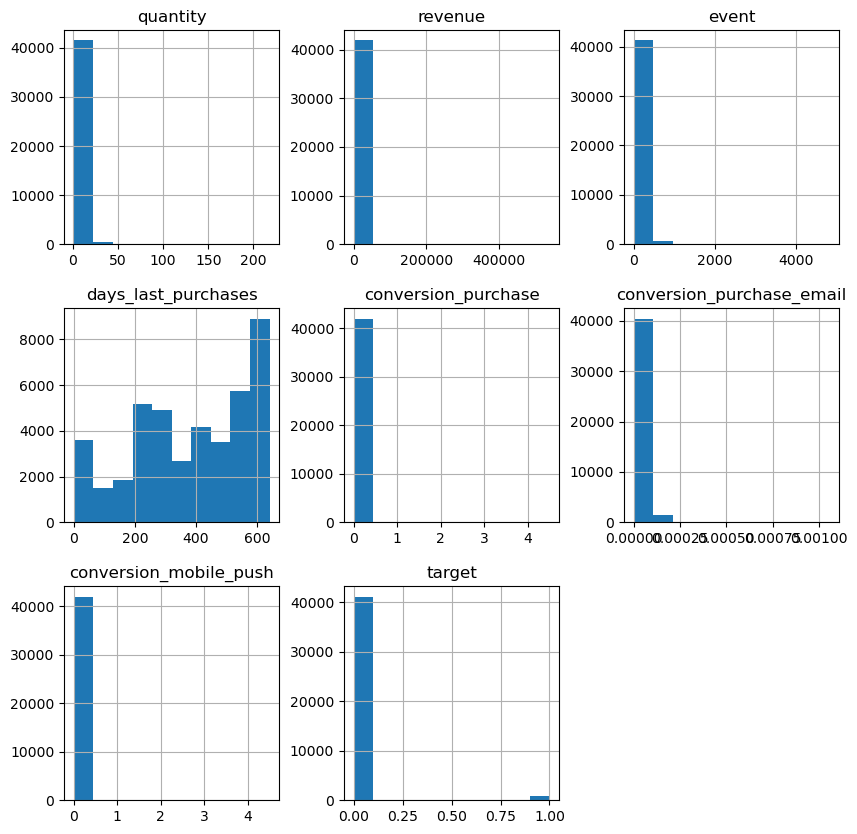

In [54]:
data.hist(figsize = (10, 10));

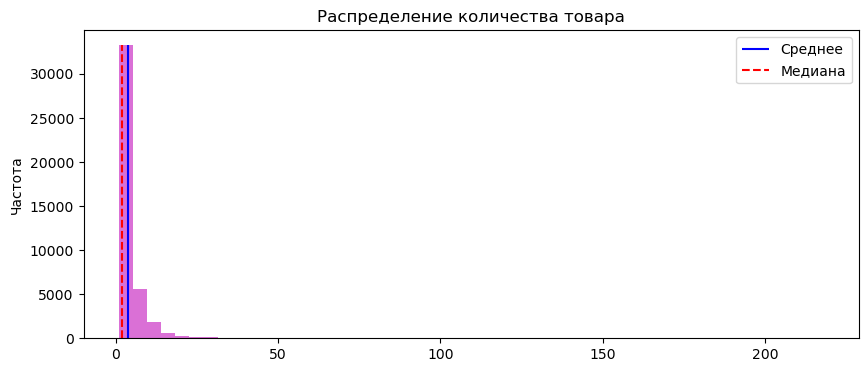

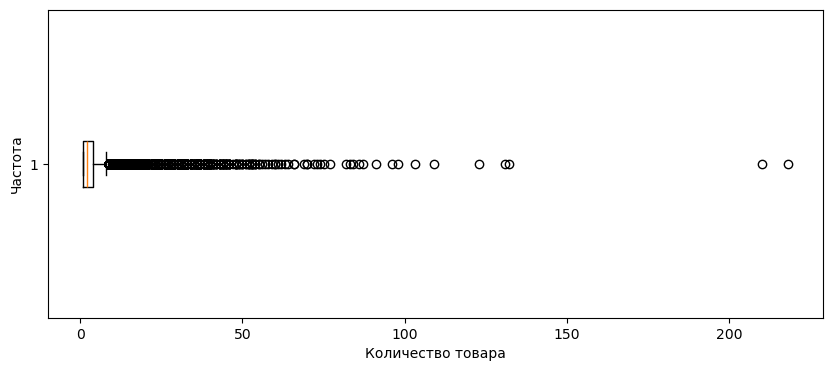

count    41981.000000
mean         3.863510
std          5.233286
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        218.000000
Name: quantity, dtype: float64

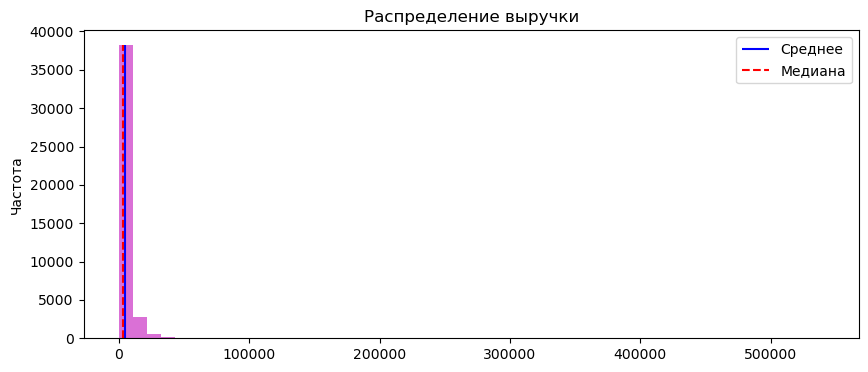

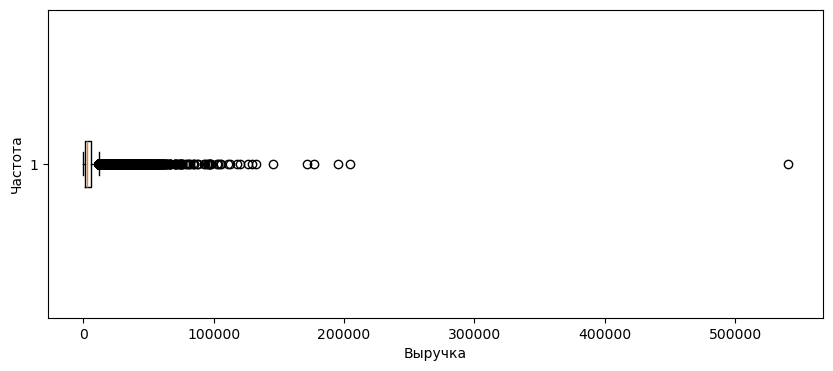

count     41981.000000
mean       4787.530025
std        7153.610139
min           1.000000
25%        1499.000000
50%        2860.000000
75%        5598.000000
max      540408.000000
Name: revenue, dtype: float64

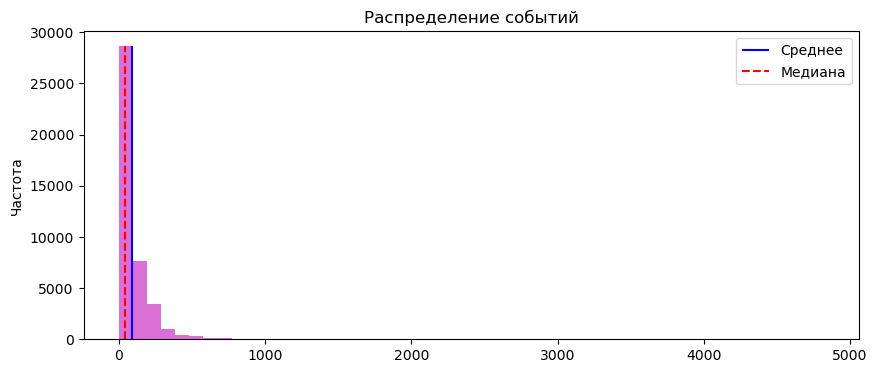

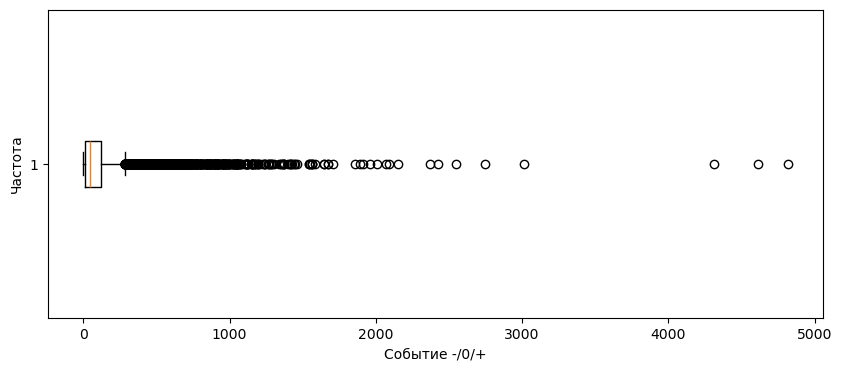

count    41981.000000
mean        89.757867
std        134.519470
min          0.000000
25%         12.000000
50%         44.000000
75%        122.000000
max       4818.000000
Name: event, dtype: float64

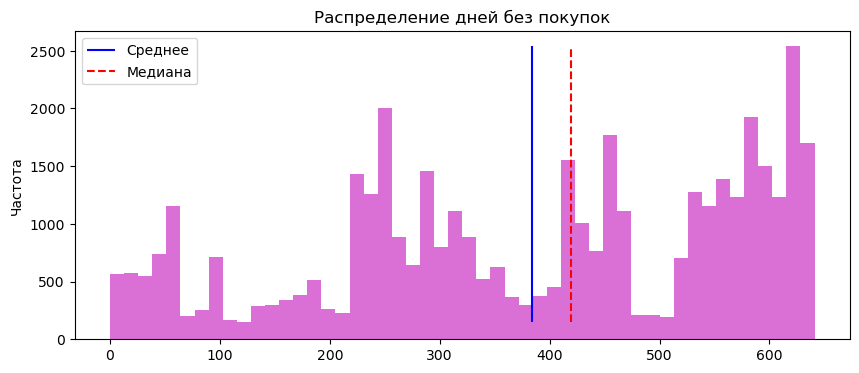

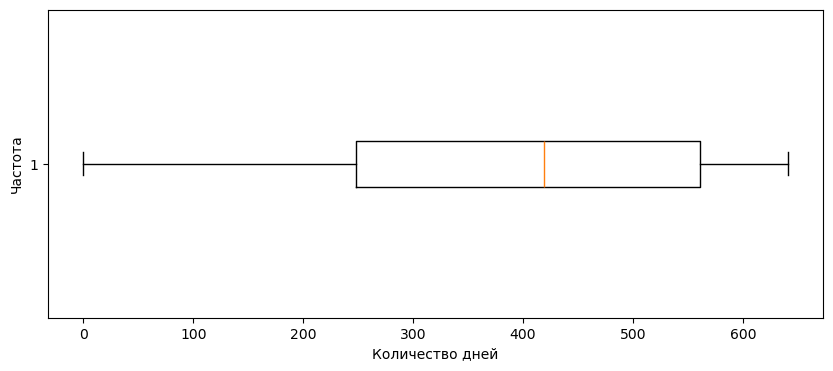

count    41981.000000
mean       383.858122
std        186.432628
min          0.000000
25%        248.000000
50%        419.000000
75%        561.000000
max        641.000000
Name: days_last_purchases, dtype: float64

In [55]:
eda_number(data, 'quantity', 'Распределение количества товара', 'Количество товара', 'orchid')
eda_number(data, 'revenue', 'Распределение выручки', 'Выручка', 'orchid')
eda_number(data, 'event', 'Распределение событий', 'Событие -/0/+', 'orchid')
eda_number(data, 'days_last_purchases', 'Распределение дней без покупок', 'Количество дней', 'orchid')

Выбросы в данных не обнаружены, мы исследуем сгруппированные данные, поэтому в количестве редкие значения это нормально . 

In [56]:
#разделим датасет на два по целевому признаку
data_1 = data[data['target'] == 1]
data_0 = data[data['target'] == 0]

#### Исследовательский анализ данных категориальныхм признаков

In [57]:
def eda_number_with_target(column, title, xlabel):
    #делаем таблица со статистикой для data_train_1 и data_train_0 в одной таблице
    desc_1 = data_1[column].describe()
    desc_0 = data_0[column].describe()
    combined_desc = pd.concat([desc_1, desc_0], axis=1)
    combined_desc.columns = ['Купит', 'Не купит']
    print(combined_desc)

    #добавляем 2 гистограммы на один график
    plt.hist(data_train_1[column], bins=50, alpha=0.3, label='operating', color='orchid')
    plt.hist(data_train_0[column], bins=50, alpha=0.3, label='closed')
    # Добавление подписей осей
    plt.xlabel(xlabel)
    plt.ylabel('Частота')
    plt.title(title)
    plt.legend()
    plt.show()

In [58]:
print(data.select_dtypes(exclude=['number', 'datetime']).columns.tolist())

['category_ids_new', 'channel']


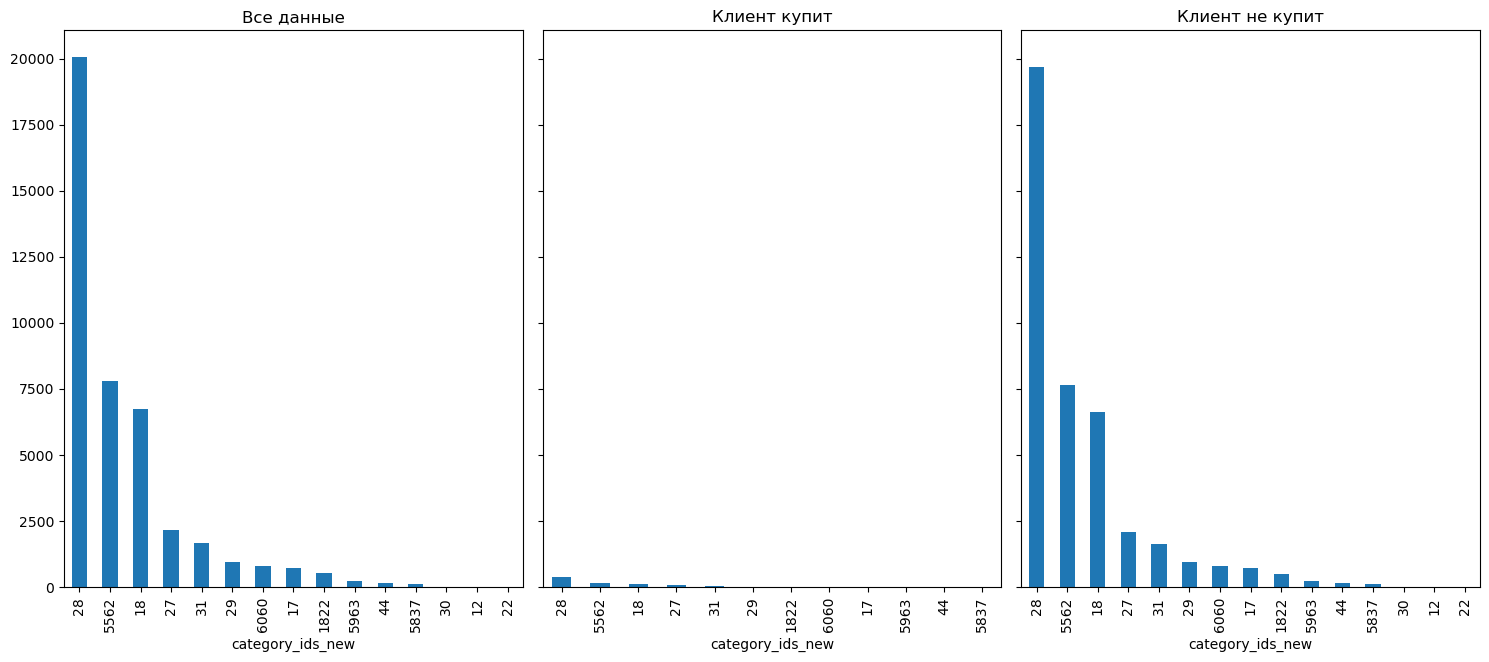

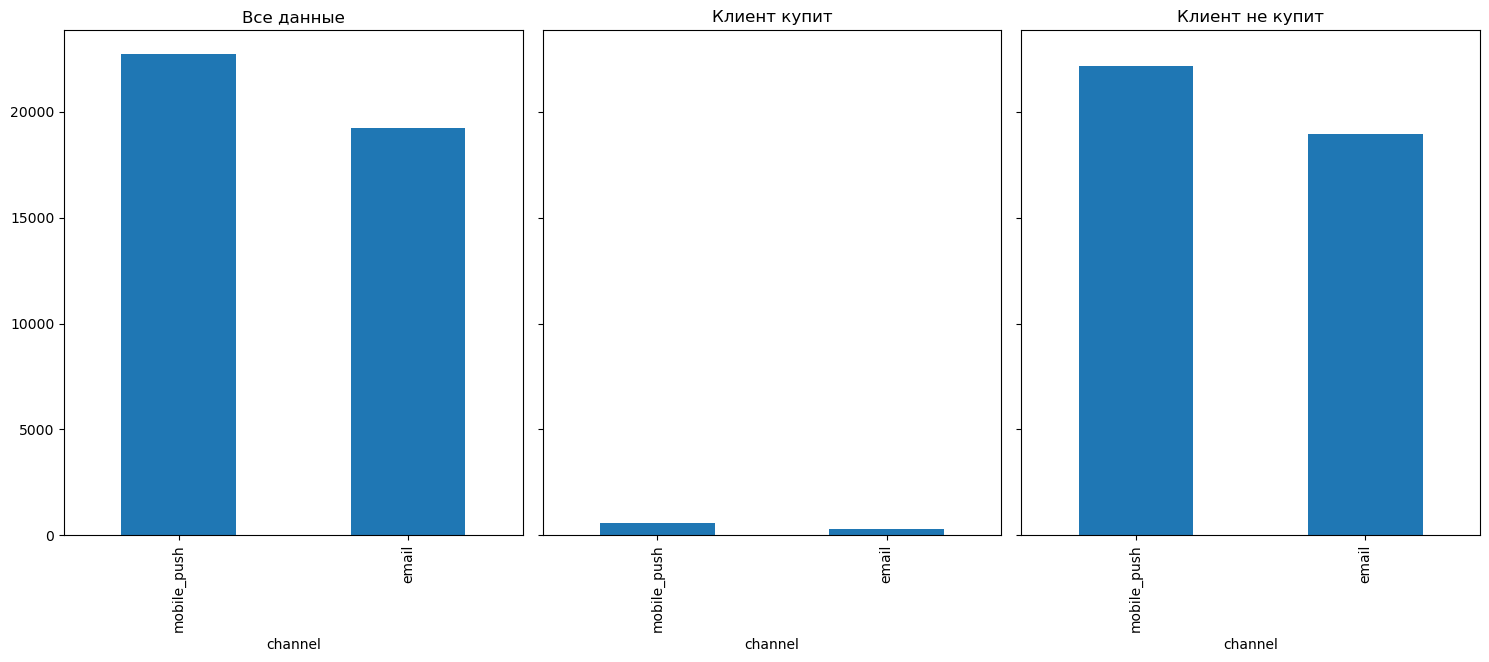

In [59]:
eda_category('category_ids_new', 'Распределение по категориям')
eda_category('channel', 'Распределение по каналам')

#### Корреляционный анализ признаков

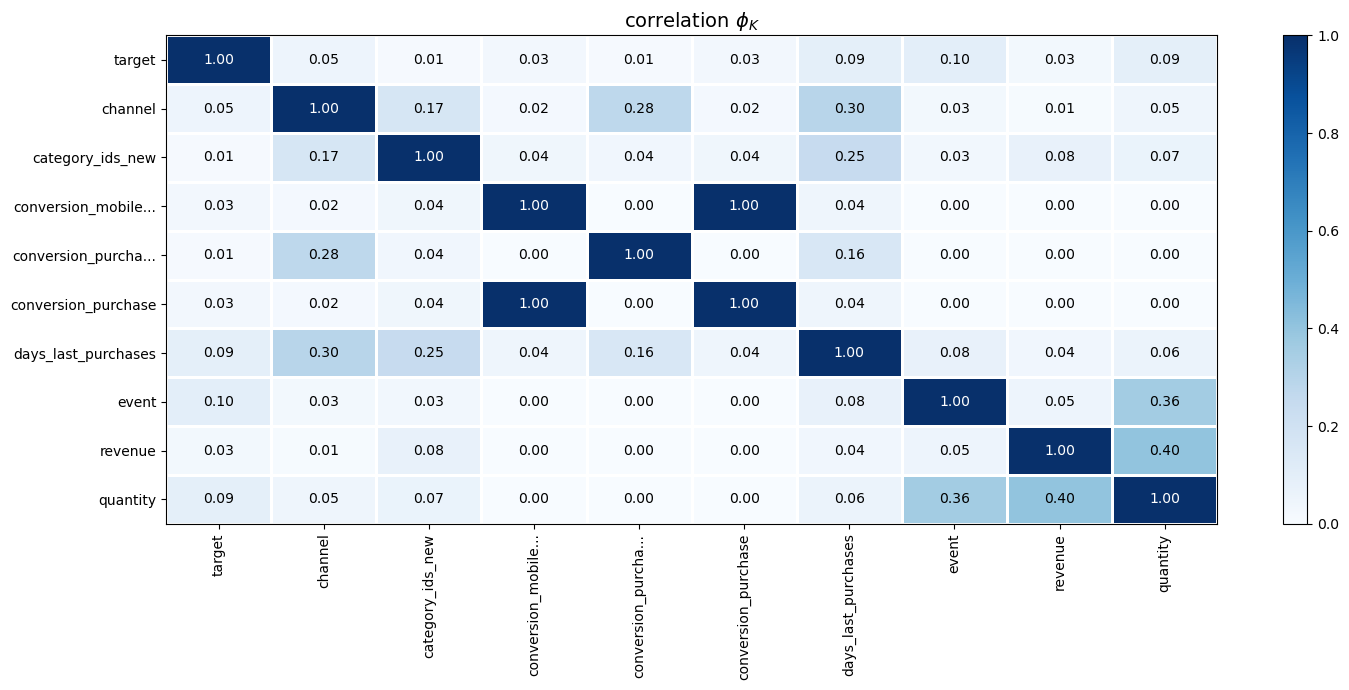

In [60]:
num_columns=data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=num_columns)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Blues', 
                        title=r'correlation $\phi_K$', fontsize_factor=1, figsize=(15, 7)) 
plt.tight_layout()
plt.show()

In [61]:
# эксперимент - обучеие на наборе данных без конверсий не показал улучшений в метрике

data = data.drop(columns=['conversion_purchase_email', 'conversion_mobile_push'])

На данном этапе проведен исследовательский анализ данных.

Были проверены все числовые и категориальные признаки, постороены гистраграммы и столбчатые диаграммы как по всем данным тренировочного датасета, так и в разрезе высокой и низкой удовлетворенности сотрудников.

Аномалии и выбросы не выявлены.

Все признаки слабо коррелируют с трагетом , но наибольшую зависимость показывают событие, количество купленного товара, количество дней без покупок.


Мультиколлинеарность принято учитывать при корреляции признаков выше 0.9, такая сильная зависимость в данных есть между конверсиями. Удалим некоторые конверсии.

### Выводы по результатам шага

## Обучение моделей

### Подготовка данных к обучению

In [62]:
#разобьем данные на тренировочные, валидационные и тестовые входные и целевой признаки
X_train, X_temp, y_train, y_temp = train_test_split(
        data.drop(['target'], axis=1),
        data['target'],
        stratify=data['target'],
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,   
    )




X_test, X_valid, y_test, y_valid = train_test_split(
        X_temp,
        y_temp,
        test_size=0.5,
        stratify=y_temp,
        random_state=RANDOM_STATE,   
    )
# проверяем размерность выборок
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('X_valid', X_valid.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_valid', y_valid.shape)


X_train (31485, 7)
X_test (5248, 7)
X_valid (5248, 7)
y_train (31485,)
y_test (5248,)
y_valid (5248,)


In [63]:
#разделим колонки на числовы и категориальные
# создаем список числовых признаков

num_columns = data.select_dtypes(include='number').drop(['target'], axis=1).columns.tolist()
cat_columns = data.select_dtypes(exclude='number').columns.tolist()
target = 'target'

print('Числовые колонки:', num_columns)
print('Категориальные колонки:', cat_columns)
print('Целевая переменная:', target)

Числовые колонки: ['quantity', 'revenue', 'event', 'days_last_purchases', 'conversion_purchase']
Категориальные колонки: ['category_ids_new', 'channel']
Целевая переменная: target


Проанализируем время обучения, время предсказания и качество моделей. Создадим функцию для подсчета времени обучения, предсказания и для метрик. Для оценки качества модели используем метрику ROC-AUC.

In [64]:
def fit_predict_time(model, X_valid, y_valid):
    
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Время обучения: {train_time:.4f} секунд")
    
    # Измеряем время предсказания
    start_time = time.time()
    y_pred = model.predict(X_valid)
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f"Время предсказания: {prediction_time:.4f} секунд")

    

### Модели DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression

In [65]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline([   
    ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')),
    ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Создаем пайплайн для подготовки признаков из списка num_columns
# проводим масштабирование, Используем StandardScaler по умолчанию
num_pipe = Pipeline([
    ('scaler', StandardScaler())  
])


data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, cat_columns),
            ('num', num_pipe, num_columns)
        ],
        remainder='passthrough'
    )


In [66]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.2)),
    ('models', KNeighborsClassifier())
])

param_distributions = [
   #словарь для модели DecisionTreeClassifier
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(1, 15),
        'models__max_features': range(1, 12),
        'models__min_samples_split': range(1, 12),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
   },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 13),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] #указываем только название скейлера  
    },
    
    #словарь для модели LogisticRegression
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.01, 0.1, 10, 17],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'lbfgs'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    } 
]

#перебор вариантов масштабирования и  гипермараметров модели


randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,

)

randomized_search.fit(X_train, y_train)

C:\Users\PC\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PC\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PC\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\PC\anaconda3\Lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\PC\anaconda3\Lib\site-packages\sklearn\tre

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('simpleImputer_after_ohe',
                                                                                                SimpleImputer(strategy='most_...
                                                                       'passthrough']},
                                        {'models': [LogisticRegression(C=17,
                                                                       class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=77,
                                                                       solver='liblinear')],
                                         'models__C': [0.01, 0.1, 10, 17],
                                         'models__penalty': ['l1', 'l2'],
                                         'models__solver': ['liblinear',
                                                            'lbfgs'],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       RobustScaler(),
                                                                       'passthrough']}],
                   random_state=77, scoring='roc_auc')

In [67]:
y_pred = randomized_search.predict(X_valid)
y_pred_proba = randomized_search.predict_proba(X_valid)[:, 1]

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Лучший скейлер:', randomized_search.best_params_['preprocessor__num__scaler'])
print('ROC-AUC  на тренировочной выборке:', randomized_search.best_score_)
print('F1 на валидационной выборке:', f1_score(y_valid, y_pred))
print('ROC-AUC на валидационной выборке:', roc_auc_score(y_valid, y_pred_proba))
fit_predict_time(randomized_search.best_estimator_, X_valid, y_valid)
print('Precision на валидационной выборке:', precision_score(y_valid, y_pred))
print('Recall на валидационной выборке:', recall_score(y_valid, y_pred))
cm = confusion_matrix(y_valid, y_pred)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
cm_df

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                              

,Pred 0,Pred 1
True 0,3673,1469
True 1,46,60


### Модель CatBoost

In [68]:
cbr_model = CatBoostClassifier(cat_features = cat_columns, 
                              iterations=100,
                              verbose=0, 
                              random_seed=RANDOM_STATE,
                              #early_stopping_rounds=18,
                              auto_class_weights='Balanced'
                              )

#Проверка и преобразование типов
for col in cat_columns:
    X_train[col] = X_train[col].astype('category') 


# Сетка гиперпараметров для RandomizedSearchCV
param_distributions = {  
    'learning_rate': np.random.uniform(0.05, 0.1, 3),  
    'depth': np.random.randint(4, 8, 12)
}

randomized_search_cbr = RandomizedSearchCV(
    estimator=cbr_model,
    param_distributions=param_distributions,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Обучаем модель
randomized_search_cbr.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002CB8A84C750>,
                   n_jobs=-1,
                   param_distributions={'depth': array([5, 6, 5, 5, 5, 6, 6, 6, 7, 5, 7, 4]),
                                        'learning_rate': array([0.0760711 , 0.08526999, 0.05315879])},
                   random_state=77, scoring='roc_auc')

In [69]:
y_pred = randomized_search_cbr.predict(X_valid)
y_pred_proba = randomized_search_cbr.predict_proba(X_valid)[:, 1]

print('Лучшая модель и её параметры:\n\n', randomized_search_cbr.best_estimator_)

print('ROC-AUC  на тренировочной выборке:', randomized_search_cbr.best_score_)
print('F1 на валидационной выборке:', f1_score(y_valid, y_pred))
print('ROC-AUC на валидационной выборке:', roc_auc_score(y_valid, y_pred_proba))
print('Precision на валидационной выборке:', precision_score(y_valid, y_pred))
print('Recall на валидационной выборке:', recall_score(y_valid, y_pred))
fit_predict_time(randomized_search_cbr.best_estimator_, X_valid, y_valid)
cm = confusion_matrix(y_valid, y_pred)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
cm_df

Лучшая модель и её параметры:

ROC-AUC  на тренировочной выборке: 0.7420595236510431
F1 на валидационной выборке: 0.08118081180811809
ROC-AUC на валидационной выборке: 0.7240098192466039
Precision на валидационной выборке: 0.04342105263157895
Recall на валидационной выборке: 0.6226415094339622
Время обучения: 2.7698 секунд
Время предсказания: 0.0140 секунд


,Pred 0,Pred 1
True 0,3688,1454
True 1,40,66


## Анализ моделей

LogisticRegression(C=17, class_weight='balanced', penalty='l1', random_state=77, solver='liblinear'))])  
Лучший скейлер: passthrough  
ROC-AUC  на тренировочной выборке: 0.7152677277375907  
ROC-AUC на валидационной выборке: 0.7113339644657757  
F1 на валидационной выборке: 0.07339449541284403  
Precision на валидационной выборке: 0.03924133420536298  
Recall на валидационной выборке: 0.5660377358490566  
Время обучения: 0.3012 секунд  
Время предсказания: 0.0110 секунд

Catboost    
ROC-AUC  на тренировочной выборке: 0.7434852994230727  
F1 на валидационной выборке: 0.08433734939759036  
ROC-AUC на валидационной выборке: 0.7311907854663408  
Precision на валидационной выборке: 0.04504504504504504  
Recall на валидационной выборке: 0.660377358490566  
Время обучения: 2.1084 секунд  
Время предсказания: 0.0110 секунд  

## Проверка модели на тестовой выборке

In [70]:
best_model = randomized_search_cbr.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


print('F1 на тестовой выборке:', f1_score(y_test, y_pred))
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_proba))

print('Precision на тестовой выборке:', precision_score(y_test, y_pred))   
print('Recall на тестовой выборке:', recall_score(y_test, y_pred))
fit_predict_time(best_model, X_test, y_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
cm_df

F1 на тестовой выборке: 0.07951807228915662
ROC-AUC на тестовой выборке: 0.7190891878206117
Precision на тестовой выборке: 0.04247104247104247
Recall на тестовой выборке: 0.6226415094339622
Время обучения: 3.1275 секунд
Время предсказания: 0.0130 секунд


,Pred 0,Pred 1
True 0,3654,1488
True 1,40,66


Попробуем сдвинуть порог предсказания , попробуем повысить Recall, так как для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время. Но при этом ухудшится Precision, но в нашем случае это не так важно, нам главное не упустить клиентов , которые точно планируют совершить покупку. поэтому снижаем Precision и увеличиваем Recall.
Низкая метрика Precision (точность) означает, что из всех объектов, которые модель отнесла к положительному классу (предсказала как 1), лишь малая доля действительно принадлежит этому классу. Другими словами, много ложных срабатываний (False Positives). 

In [71]:
threshold = 0.38
y_pred_01 = (y_pred_proba >= threshold).astype(int)  

cm = confusion_matrix(y_test, y_pred_01)
cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])
print('Precision на тестовой выборке:', precision_score(y_test, y_pred_01))   
print('Recall на тестовой выборке:', recall_score(y_test, y_pred_01))
print('F1 на тестовой выборке:', f1_score(y_test, y_pred_01))
print('ROC-AUC на тестовой выборке:', roc_auc_score(y_test, y_pred_proba))
cm_df

Precision на тестовой выборке: 0.03218210361067504
Recall на тестовой выборке: 0.7735849056603774
F1 на тестовой выборке: 0.06179351921627732
ROC-AUC на тестовой выборке: 0.7190891878206117


,Pred 0,Pred 1
True 0,2676,2466
True 1,24,82


## Общий вывод 

Задачей данного проекта было создание модели которая сможет на основе данных  о покупках и рассылках клиентов за несколько лет сможет предсказать совершит ли клиент покупку еще раз. Данные модели смогут помочь маркетологам идентифицировать и простимулировать спрос покупателей, которые не планируют делать покупки с помощью промокодов и корректировки рассылки.

В ходе выполнения проекта были загружены, обработаны и исследованы данные о покупках и рассылках за 2022-2024гг. Была проведена предобработка данных, удалены дубликаты, агрегированы и объеденины данные в один датасет, проведен исследовательский и корреляционый анализ данных.

Были проверены все числовые и категориальные признаки, постороены гистраграммы и столбчатые диаграммы как по всем данным объединенного датасета, так и в разрезе покупательских планов клиентов.


Для обучения использовалось несколько моделей с перебором параметров - DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, CatBoost.  Лучшей моделью признана:

Модель , позволяющая спрогнозировать совершит покупатель покупку или нет: Catboost  
Полученные метрики:  
ROC-AUC  на тренировочной выборке: 0.7434852994230727  
F1 на валидационной выборке: 0.08433734939759036  
ROC-AUC на валидационной выборке: 0.7311907854663408  
Precision на валидационной выборке: 0.04504504504504504  
Recall на валидационной выборке: 0.660377358490566  
Время обучения: 2.1084 секунд  
Время предсказания: 0.0110 секунд    

Было произведено прогнозирование на тестовой выборке и получены следующие метрики (с порогом 0,37):  
Precision на тестовой выборке: 0.031526336024605923  
Recall на тестовой выборке: 0.7735849056603774  
F1 на тестовой выборке: 0.060583671961581084  
ROC-AUC на тестовой выборке: 0.7242079654785232   

Рекомендации по улучшению работы модель: необходимо уделить внимание предобработке данных, необходимо получить разъяснения по категориям товаров, чтобы иметь более ясное представление о том , что означает категория на каждом уровне. Модель имеет низкую метрику precision / recall и f1, что модель очень низкую точность.


*Евгений, вопрос: подскажи, пожалуйста, нужно ли нам стараться поймать баланс, или нам необходимо выкрутить recall на максимум, снизив порог, и предсказать все 1 как 1, которых и так мало, чтобы не упустить прибыль от тех клиентов (тру класс 1), которые запланировали покупку. Либо нам нужно одновременно следить за метрикой precision и не предсказывать слишком много лишних 1, которые на самом-то деле 0 , чтобы  не тратить средства на привлечение этих клиентов (тру класс 0)?*